# Source Detection

 work with Weakly_2023_44
- use jupyter kernel LSST
- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date : 2024/01/07
- update : 2024/01/07


In [1]:
# General python packages
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# LSST Science Pipeline packages (see pipelines.lsst.io)
import lsst.daf.base as dafBase
from lsst.daf.butler import Butler
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
import lsst.afw.table as afwTable
import lsst.geom as geom

# Pipeline tasks
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.deblender import SourceDeblendTask
from lsst.meas.base import SingleFrameMeasurementTask

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm


import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.io import fits

import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd
import pickle

plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [3]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.time import Time


In [4]:
# LSST Display
plt.style.use('tableau-colorblind10')
afwDisplay.setDefaultBackend('matplotlib')
plt.rcParams['figure.figsize'] = (8.0, 8.0)

In [5]:
transform = AsinhStretch() + PercentileInterval(99.)

In [6]:
pd.options.display.max_columns = None
#pd.options.display.max_rows = None

In [7]:
#repo =  "/sdf/group/rubin/repo/main"
repo = "/sdf/group/rubin/repo/oga/"
my_collection = "LATISS/runs/AUXTEL_DRP_IMAGING_2023-11A-10A-09AB-08ABC-07AB-05AB/w_2023_46/PREOPS-4553"

In [8]:
butler = Butler(repo,collections=my_collection)
registry = butler.registry

## Load Visits

In [9]:
filevisit_in = "ccdVisitTable_202312.csv"

In [10]:
df = pd.read_csv(filevisit_in)

In [11]:
df

,ccdVisitId,visitId,physical_filter,band,ra,dec,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,decl,detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,nightObs,Time,airmass,tractID,patchID,selectedFlag,dayobsMJD
0,40919696896,2023051100262,SDSSr_65mm~empty,r,239.946727,-24.053746,56.749516,27.705477,7.776608,11.197219,7.856582,0.032861,0.019685,39,-0.004245,-0.001485,0.031742,0.014841,0.089763,0.063628,0.008093,0.659493,1402.7019,-24.053746,0,1.752650,322.911701,2023-05-12 01:08:56.302993,60076.047874,30.0,2023-05-12 01:08:41.302993,60076.047700,30.2434,4071,3999,239.935566,-24.128925,240.029264,-24.062574,239.957874,-23.978566,239.864200,-24.044873,20230511,2023-05-12 01:08:41.302993,1.823818,5615,295,False,60076
1,40919697152,2023051100263,SDSSg_65mm~empty,g,239.941335,-24.038380,56.289413,27.909496,7.784901,3.989901,7.472743,0.032879,0.018671,20,0.012385,0.007139,0.029436,0.042836,0.158896,0.171208,0.021377,5.179351,2200.9622,-24.038380,0,1.754600,170.005077,2023-05-12 01:11:06.209005,60076.049377,30.0,2023-05-12 01:10:51.209005,60076.049204,30.2343,4071,3999,239.988740,-23.976092,239.872262,-23.996196,239.893883,-24.100653,240.010453,-24.080532,20230511,2023-05-12 01:10:51.209005,1.801808,5615,295,False,60076
2,40919697408,2023051100264,SDSSi_65mm~empty,i,239.938163,-24.036848,55.439133,27.848541,6.357665,28.071854,8.586543,0.026557,0.017523,35,0.012835,-0.013177,0.020933,0.046253,-0.012802,0.100489,0.015865,0.367621,1484.0870,-24.036848,0,1.432899,170.004955,2023-05-12 01:15:04.912000,60076.052140,30.0,2023-05-12 01:14:49.912000,60076.051967,30.2335,4071,3999,239.985572,-23.974553,239.869113,-23.994653,239.890709,-24.099128,240.007259,-24.079011,20230511,2023-05-12 01:14:49.912000,1.762794,5615,295,False,60076
3,40919698432,2023051100268,SDSSr_65mm~empty,r,239.964413,-24.045511,54.482190,27.753105,8.100518,10.701076,7.854048,0.026480,0.014894,32,-0.001825,-0.007242,0.012690,0.015632,0.152651,0.114754,0.013798,0.492981,2023.0471,-24.045511,0,1.825550,323.867206,2023-05-12 01:19:39.311494,60076.055316,30.0,2023-05-12 01:19:24.311494,60076.055142,30.2379,4071,3999,239.951868,-24.120504,240.046768,-24.055597,239.976943,-23.970518,239.882070,-24.035382,20230511,2023-05-12 01:19:24.311494,1.721301,5615,294,False,60076
4,40919698944,2023051100270,SDSSi_65mm~empty,i,239.961137,-24.046364,53.849277,27.852003,6.746165,23.952093,8.440446,0.023563,0.012609,34,-0.011282,0.003969,0.037771,0.022550,-0.016428,0.143892,0.020965,1.172335,1726.0397,-24.046364,0,1.520463,170.004124,2023-05-12 01:22:36.150002,60076.057363,30.0,2023-05-12 01:22:21.150002,60076.057189,30.2424,4071,3999,240.008536,-23.984061,239.892087,-24.004162,239.913693,-24.108652,240.030233,-24.088535,20230511,2023-05-12 01:22:21.150002,1.695170,5615,294,False,60076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1650,42438060288,2023110800361,SDSSr_65mm~empty,r,12.472362,-72.844737,44.729496,27.849432,5.733940,7.405540,8.019971,0.021888,0.013789,56,-0.009452,-0.008703,0.024639,0.027964,-0.085554,0.168348,0.029979,0.591626,1244.2625,-72.844737,0,1.292204,0.005046,2023-11-09 04:07:51.959003,60257.172129,30.0,2023-11-09 04:07:36.959003,60257.171956,30.2341,4071,3999,12.290521,-72.898489,12.658600,-72.897144,12.653100,-72.790823,12.287227,-72.792161,20231108,2023-11-09 04:07:36.959003,1.407584,383,360,False,60257
1651,42438060544,2023110800362,empty~SDSSi_65mm,i,12.473520,-72.844725,44.762394,27.866250,5.811111,17.281977,8.557647,0.021350,0.014090,60,0.001978,-0.005822,0.018680,0.019

In [12]:
tract_selected = 5615
patch_selected = 294
nightObs_selected = 20230803

In [13]:
cut1 = (df.nightObs == nightObs_selected) 
cut2 =  (df.tractID == tract_selected) 
cut3 = (df.patchID == patch_selected) 	

In [14]:
cut = cut1 & cut2 & cut3

In [15]:
df = df[cut]

In [16]:
df

,ccdVisitId,visitId,physical_filter,band,ra,dec,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,decl,detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,nightObs,Time,airmass,tractID,patchID,selectedFlag,dayobsMJD
889,41624376832,2023080300406,SDSSg_65mm~empty,g,240.041785,-24.048094,21.034332,28.057058,6.660395,17.902174,8.061447,0.020317,0.009605,30,-0.010696,-0.001133,0.013134,0.018914,-0.029648,0.095334,0.014355,0.252011,1313.13680,-24.048094,0,1.500956,359.999299,2023-08-04 01:25:47.967505,60160.059583,30.0,2023-08-04 01:25:32.967505,60160.059409,30.2347,4071,3999,239.983254,-24.101950,240.101815,-24.100552,240.100267,-23.994216,239.981804,-23.995613,20230803,2023-08-04 01:25:32.967505,1.071392,5615,294,False,60160
890,41624377088,2023080300407,SDSSi_65mm~empty,i,240.041860,-24.048144,21.191198,27.925398,5.163197,19.430489,8.142155,0.010760,0.005159,59,-0.007687,-0.019075,0.028860,0.026144,-0.026698,0.078612,0.015153,0.374370,1305.16590,-24.048144,0,1.163353,359.999309,2023-08-04 01:26:32.320001,60160.060096,30.0,2023-08-04 01:26:17.320001,60160.059923,30.2399,4071,3999,239.983345,-24.101978,240.101892,-24.100600,240.100325,-23.994289,239.981876,-23.995665,20230803,2023-08-04 01:26:17.320001,1.072525,5615,294,False,60160
894,41624378368,2023080300412,SDSSg_65mm~empty,g,239.977785,-24.018685,22.579422,28.009050,6.639405,19.090520,8.143469,0.025244,0.016126,25,0.001604,-0.000548,0.011268,0.010432,0.047788,0.070625,0.010413,0.531701,1954.74490,-24.018685,0,1.496152,359.999292,2023-08-04 01:32:45.192999,60160.064412,30.0,2023-08-04 01:32:30.192999,60160.064238,30.2323,4071,3999,239.919276,-24.072530,240.037800,-24.071151,240.036245,-23.964817,239.917819,-23.966195,20230803,2023-08-04 01:32:30.192999,1.083015,5615,294,False,60160
895,41624378624,2023080300413,SDSSi_65mm~empty,i,239.977845,-24.018755,22.737123,27.884607,5.151424,19.391745,8.152251,0.009830,0.006332,43,0.008024,0.000927,0.017009,0.017825,-0.018612,0.112808,0.021782,0.401399,1274.83870,-24.018755,0,1.160741,359.999316,2023-08-04 01:33:29.554994,60160.064925,30.0,2023-08-04 01:33:14.554994,60160.064752,30.2415,4071,3999,239.919341,-24.072595,240.037860,-24.071212,240.036300,-23.964892,239.917879,-23.966274,20230803,2023-08-04 01:33:14.554994,1.084260,5615,294,False,60160
897,41624379648,2023080300417,SDSSr_65mm~empty,r,239.961572,-24.048283,23.403173,27.839767,5.844991,14.464193,7.937201,0.014984,0.008550,46,0.000695,0.002199,0.015260,0.016875,-0.013060,0.091968,0.015700,0.645898,1393.73620,-24.048283,0,1.317041,359.999176,2023-08-04 01:36:35.671995,60160.067080,30.0,2023-08-04 01:36:20.671995,60160.066906,30.2404,4071,3999,239.903051,-24.102123,240.021600,-24.100743,240.020043,-23.994421,239.901593,-23.995800,20230803,2023-08-04 01:36:20.671995,1.089642,5615,294,False,60160
898,41624379904,2023080300418,SDSSg_65mm~empty,g,239.961518,-24.048301,23.561365,28.048530,6.554672,19.696959,8.197164,0.021153,0.010923,30,-0.001236,-0.010007,0.007918,0.022446,0.042083,0.065772,0.009861,0.494412,1695.62020,-24.048301,0,1.477085,0.001370,2023-08-04 01:37:20.025505,60160.067593,30.0,2023-08-04 01:37:05.025505,60160.067419,30.2373,4071,3999,239.902996,-24.102151,240.021548,-24.100766,240.019991,-23.994429,239.901537,-23.995813,20230803,2023-08-04 01:37:05.025505,1.090950,5615,294,False,60160
899,41624380160,2023080300419,SDSSi_65mm~empty,i,239.961612,-24.048356,23.719357,27.885946,6.281740,19.773745,8.193923,0.013312,0.007301,46,0.006779,-0.001743,0.022594,0.015273,-0.001669,0.153275,0.024398,0.863445,1110.00890,-24.048356,0,1.415441,359.999313,2023-08-04 01:38:04.344499,60160.068106,30.0,2023-08-04 01:37:49.344499,60160.067932,30.2445,407

In [17]:
# Define the dataId using just visit and detector
dataId = {'visit': 2023080300406,'instrument':"LATISS", 'detector': 0}

# Use the butler to get the calexp
calexp = butler.get('calexp', **dataId, collections=my_collection)

<br>

As described in other tutorials, the `calexp` object possesses more than just the raw pixel data of the image. It also contains a `mask`, which stores information about various pixels in a bit mask.

Here are some optional commands to explore the calexp. Uncomment one of the code lines to learn more.

In [18]:
# If you want to investigate the contents of the masked image:
#calexp.maskedImage

# If you just want one of the three components:
# calexp.maskedImage.image
# calexp.maskedImage.mask
# calexp.maskedImage.variance

# These also work:
# calexp.image
# calexp.mask
# calexp.variance

# The calexp also contains the PSF, the WCS, and the photometric calibration
#calexp.getPsf()
#calexp.getWcs()
#calexp.getPhotoCalib()

Since we are interested in performing our own source detection and measurement, we choose to clear the existing `DETECTED` mask plane.

In [19]:
# Unset the `DETECTED` bits of the mask plane
calexp.mask.removeAndClearMaskPlane('DETECTED')

In [20]:
calexp.mask

lsst.afw.image._image.MaskX=[[ 16  16 528 ...  16  16  16]
 [ 16  16  16 ...  16  16  16]
 [ 16  16  16 ...  16  16  16]
 ...
 [ 16  16  16 ...  16  16  16]
 [ 16  16  16 ...  16  16  16]
 [ 16  16 528 ...  16  16  16]], bbox=(minimum=(0, 0), maximum=(4071, 3999)), maskPlaneDict={'BAD': 0, 'CR': 3, 'CROSSTALK': 9, 'DETECTED_NEGATIVE': 6, 'EDGE': 4, 'INTRP': 2, 'NOT_DEBLENDED': 10, 'NO_DATA': 8, 'SAT': 1, 'STREAK': 11, 'SUSPECT': 7, 'UNMASKEDNAN': 12}

<Figure size 1400x1400 with 0 Axes>

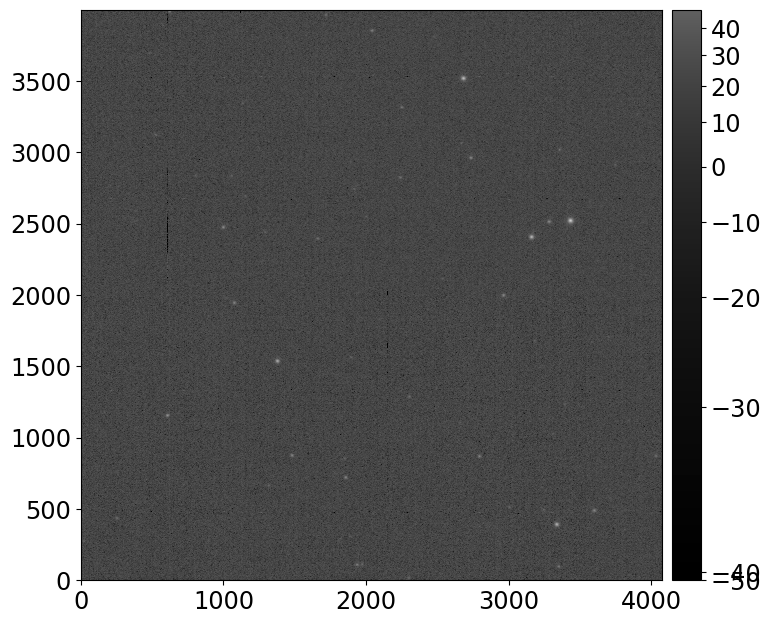

In [21]:
# Plot the calexp we just retrieved
plt.figure(figsize=(14,14))
afw_display = afwDisplay.Display()
afw_display.scale('asinh', 'zscale')
afw_display.mtv(calexp.image)

<br>

### 2.2. Add the Subtracted Sky Background Back into the Image

Here we retrieve the subtracted background for the same dataId and add it back into the image. This section is optional.

First, we obtain the `calexpBackground` object for this `dataId`.  We will again use the `butler`.

In [22]:
bkgd = butler.get('calexpBackground', **dataId)

Now, let us display the background we obtained.

Text(0.5, 1.0, 'Local Polynomial Background')

<Figure size 800x800 with 0 Axes>

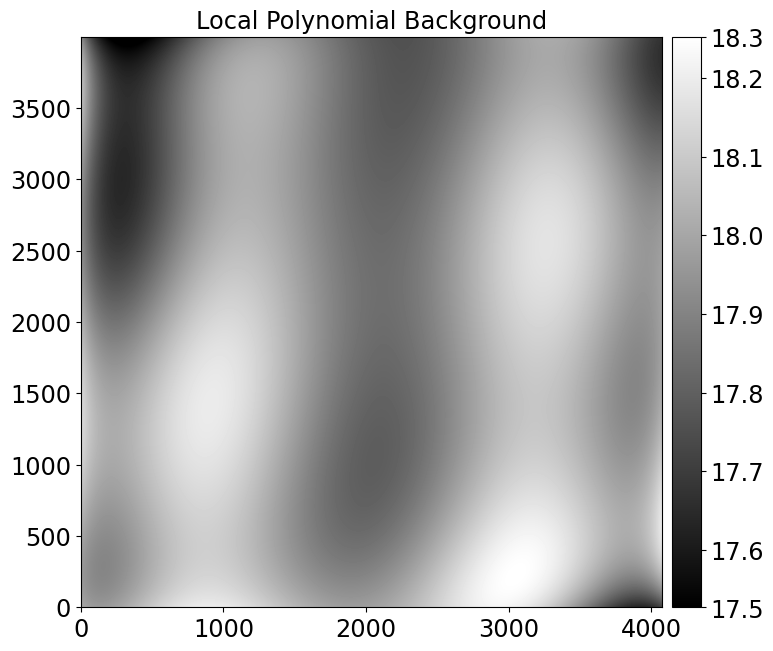

In [23]:
plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('linear', 'zscale')
afw_display.mtv(bkgd.getImage())
plt.title("Local Polynomial Background")

In [24]:
# Note: executing this cell multiple times will add the background
#  multiple times
calexp.maskedImage += bkgd.getImage()

Next, we add the background into the `calexp`, and re-display the `calexp`. Note the scale in the sidebar now goes up to thousands of counts instead of hundreds of counts.

<Figure size 800x800 with 0 Axes>

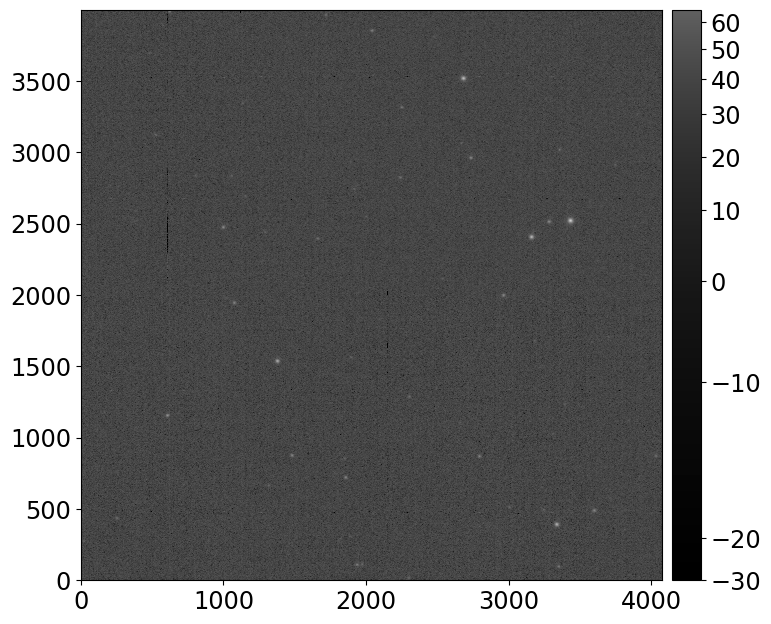

In [25]:
plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('asinh', 'zscale')
afw_display.mtv(calexp.image)

## 3. Source Detection, Deblending, and Measurement

We now want to run the LSST Science Pipelines' source detection, deblending, and measurement tasks. While we run all three tasks, this notebook is mostly focused on the detection of sources.

Recall that these tasks were imported up at the top of this notebook, from `lsst.pipe` and `lsst.meas`. More information can be found at [pipelines.lsst.io](https://pipelines.lsst.io/) (the search bar at the top left of that page is a very handy way to find documentation for a specific task).

We start by creating a minimal schema for the source table. The schema describes the output properties that will be measured for each source. This schema will be passed to all of the tasks, as we call each in turn, and each task will add columns to this schema as it measures sources in the image.

In [26]:
# Create a basic schema to use with these tasks
schema = afwTable.SourceTable.makeMinimalSchema()
print(schema)

# Create a container which will be used to record metadata
#  about algorithm execution
algMetadata = dafBase.PropertyList()
print('algMetadata: ')
algMetadata

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
)

algMetadata: 


### 3.1. Configuring Tasks

Each task possesses an associated configuration class. The properties of these configuration classes can be determined from the classes themselves.

In [27]:
# Uncomment the following line to view help
#  for the CharacterizeImageTask configuration
# Replace 'CharacterizeImageTask' with a different
#  task name to view additional help information

# 
#help(CharacterizeImageTask.ConfigClass())

As a starting point, like the `schema` and `algMetadata` above, here we set some basic config parameters and instantiate the tasks to get you started. In this case, we configure several different tasks:

* CharacterizeImageTask: Characterizes the image properties (e.g., PSF, etc.)
* SourceDetectionTask: Detects sources
* SourceDeblendTask: Deblend sources into constituent "children"
* SingleFrameMeasurementTask: Measures source properties

In [28]:
# Characterize the image properties
config = CharacterizeImageTask.ConfigClass()
config.psfIterations = 1
charImageTask = CharacterizeImageTask(config=config)

# Detect sources
config = SourceDetectionTask.ConfigClass()
# detection threshold in units of thresholdType
#config.thresholdValue = 10
config.thresholdValue = 7
# units for thresholdValue
config.thresholdType = "stdev"
sourceDetectionTask = SourceDetectionTask(schema=schema, config=config)

# Deblend sources
sourceDeblendTask = SourceDeblendTask(schema=schema)

# Measure source properties
config = SingleFrameMeasurementTask.ConfigClass()
sourceMeasurementTask = SingleFrameMeasurementTask(schema=schema,
                                                   config=config,
                                                   algMetadata=algMetadata)

Note that if you want to change the value of a config parameter (e.g., `psfIterations`), do not change it in the already constructed task. Instead, change your config object and then construct a new characterize image task. Like so:
> `config.psfIterations = 3` <br>
> `charImageTask = CharacterizeImageTask(config=config)`

Like the configs, we can use `help` to explore each task and the methods used to run it.

In [29]:
# help(charImageTask)

# Uncomment the following line, position your cursor after the period,
#  and press tab to see a list of all methods. Then recomment the line
#  because "Task." is not executable and will cause an error.
# charImageTask.

# Use the help function on any of the methods to learn more:
# help(charImageTask.writeSchemas)

# E.g., find out what options there are for config.thresholdType
# help(SourceDetectionTask.ConfigClass)

With each of the tasks configured, we can now move on to running the source detection, deblending, and measurement. First we create `SourceTable` for holding the output of our source analysis. The columns and characteristics of this table are defined by the `schema` that we created in our configuration step.

In [30]:
tab = afwTable.SourceTable.make(schema)

In [31]:
# Image characterization (this cell may take a few seconds)
result = charImageTask.run(calexp)

# Define the pixel coordinates of a point of interest
# (in this case, basically a random point within the image)
x_target, y_target = 1700, 2100
width, height = 400, 400
xmin, ymin = x_target-width//2, y_target-height//2
point = geom.Point2D(x_target, y_target)

# Get the PSF at our point of interest
psf = calexp.getPsf()
sigma = psf.computeShape(point).getDeterminantRadius()
pixelScale = calexp.getWcs().getPixelScale().asArcseconds()

# The factor of 2.355 converts from std to fwhm
print('psf fwhm = {:.2f} arcsec'.format(sigma*pixelScale*2.355))

psf fwhm = 1.30 arcsec


In [32]:
# Source detection (this cell may take a few seconds)
result = sourceDetectionTask.run(tab, calexp)
type(result)

lsst.pipe.base.struct.Struct

With the image characterized, we are now interested in running the source detection, deblending, and measurement tasks. Each of these tasks is called with the `run` method. The parameters of this method can be investigated using `help`.

In [33]:
# We are specifically interested in the `SourceMeasurementTask`
#help(sourceMeasurementTask.run)

In [34]:
for k, v in result.getDict().items():
    print(k, type(v))

positive <class 'lsst.afw.detection.FootprintSet'>
negative <class 'NoneType'>
factor <class 'float'>
factorNeg <class 'float'>
positiveThreshold <class 'lsst.afw.detection.Threshold'>
negativeThreshold <class 'lsst.afw.detection.Threshold'>
background <class 'lsst.afw.math._backgroundList.BackgroundList'>
numPos <class 'int'>
numPosPeaks <class 'int'>
numNeg <class 'int'>
numNegPeaks <class 'int'>
sources <class 'lsst.afw.table.SourceCatalog'>


In [35]:
result.numPosPeaks

151

In [36]:
sources = result.sources

In [37]:
sources.writeFits("outputTable.fits")
calexp.writeFits("example1-out.fits")

In [38]:
# Source deblending
sourceDeblendTask.run(calexp, sources)

# Source measurement
sourceMeasurementTask.run(measCat=sources, exposure=calexp)

In [39]:
# The copy makes sure that the sources are sequential in memory
sources = sources.copy(True)

# Investigate the output source catalog
sources.asAstropy()

id,coord_ra,coord_dec,parent,deblend_nChild,deblend_deblendedAsPsf,deblend_psfCenter_x,deblend_psfCenter_y,deblend_psf_instFlux,deblend_tooManyPeaks,deblend_parentTooBig,deblend_masked,deblend_failed,deblend_skipped,deblend_rampedTemplate,deblend_patchedTemplate,deblend_hasStrayFlux,deblend_peak_center_x,deblend_peak_center_y,deblend_peakId,deblend_nPeaks,deblend_parentNPeaks,base_NaiveCentroid_x,base_NaiveCentroid_y,base_NaiveCentroid_flag,base_NaiveCentroid_flag_noCounts,base_NaiveCentroid_flag_edge,base_NaiveCentroid_flag_resetToPeak,base_SdssCentroid_x,slot_Centroid_x,base_SdssCentroid_y,slot_Centroid_y,base_SdssCentroid_xErr,slot_Centroid_xErr,base_SdssCentroid_yErr,slot_Centroid_yErr,base_SdssCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianFlux_flag_badCentroid,base_LocalBackground_flag_badCentroid,base_NaiveCentroid_flag_badInitialCentroid,base_PsfFlux_flag_badCentroid,base_SdssShape_flag_badCentroid,base_Variance_flag_badCentroid,slot_Centroid_flag,base_SdssCentroid_flag_edge,base_CircularApertureFlux_flag_badCentroid_edge,base_GaussianFlux_flag_badCentroid_edge,base_LocalBackground_flag_badCentroid_edge,base_NaiveCentroid_flag_badInitialCentroid_edge,base_PsfFlux_flag_badCentroid_edge,base_SdssShape_flag_badCentroid_edge,base_Variance_flag_badCentroid_edge,slot_Centroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_CircularApertureFlux_flag_badCentroid_noSecondDerivative,base_GaussianFlux_flag_badCentroid_noSecondDerivative,base_LocalBackground_flag_badCentroid_noSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_noSecondDerivative,base_PsfFlux_flag_badCentroid_noSecondDerivative,base_SdssShape_flag_badCentroid_noSecondDerivative,base_Variance_flag_badCentroid_noSecondDerivative,slot_Centroid_flag_noSecondDerivative,base_SdssCentroid_flag_almostNoSecondDerivative,base_CircularApertureFlux_flag_badCentroid_almostNoSecondDerivative,base_GaussianFlux_flag_badCentroid_almostNoSecondDerivative,base_LocalBackground_flag_badCentroid_almostNoSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_almostNoSecondDerivative,base_PsfFlux_flag_badCentroid_almostNoSecondDerivative,base_SdssShape_flag_badCentroid_almostNoSecondDerivative,base_Variance_flag_badCentroid_almostNoSecondDerivative,slot_Centroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_CircularApertureFlux_flag_badCentroid_notAtMaximum,base_GaussianFlux_flag_badCentroid_notAtMaximum,base_LocalBackground_flag_badCentroid_notAtMaximum,base_NaiveCentroid_flag_badInitialCentroid_notAtMaximum,base_PsfFlux_flag_badCentroid_notAtMaximum,base_SdssShape_flag_badCentroid_notAtMaximum,base_Variance_flag_badCentroid_notAtMaximum,slot_Centroid_flag_notAtMaximum,base_SdssCentroid_flag_near_edge,base_CircularApertureFlux_flag_badCentroid_near_edge,base_GaussianFlux_flag_badCentroid_near_edge,base_LocalBackground_flag_badCentroid_near_edge,base_NaiveCentroid_flag_badInitialCentroid_near_edge,base_PsfFlux_flag_badCentroid_near_edge,base_SdssShape_flag_badCentroid_near_edge,base_Variance_flag_badCentroid_near_edge,slot_Centroid_flag_near_edge,base_SdssCentroid_flag_resetToPeak,base_CircularApertureFlux_flag_badCentroid_resetToPeak,base_GaussianFlux_flag_badCentroid_resetToPeak,base_LocalBackground_flag_badCentroid_resetToPeak,base_NaiveCentroid_flag_badInitialCentroid_resetToPeak,base_PsfFlux_flag_badCentroid_resetToPeak,base_SdssShape_flag_badCentroid_resetToPeak,base_Variance_flag_badCentroid_resetToPeak,slot_Centroid_flag_resetToPeak,base_SdssCentroid_flag_badError,base_CircularApertureFlux_flag_badCentroid_badError,base_GaussianFlux_flag_badCentroid_badError,base_LocalBackground_flag_badCentroid_badError,base_NaiveCentroid_flag_badInitialCentroid_badError,base_PsfFlux_flag_badCentroid_badError,base_SdssShape_flag_badCentroid_badError,base_Variance_flag_badCentroid_badError,slot_Centroid_flag_badError,base_Blendedness_old,base_Blendedness_raw,base_Blendedness_raw_child_instFlux,base_Blendedness_raw_parent_instFl

In [40]:
# Define a small region for a cutout
bbox = geom.Box2I()
bbox.include(geom.Point2I(xmin, ymin))
bbox.include(geom.Point2I(xmin + width, ymin + height))

# An alternative way to defined the same cutout region
# bbox = geom.Box2I(geom.Point2I(xmin, ymin), geom.Extent2I(width, height))

# Generate the cutout image
cutout = calexp.Factory(calexp, bbox, origin=afwImage.LOCAL, deep=False)

<Figure size 800x800 with 0 Axes>

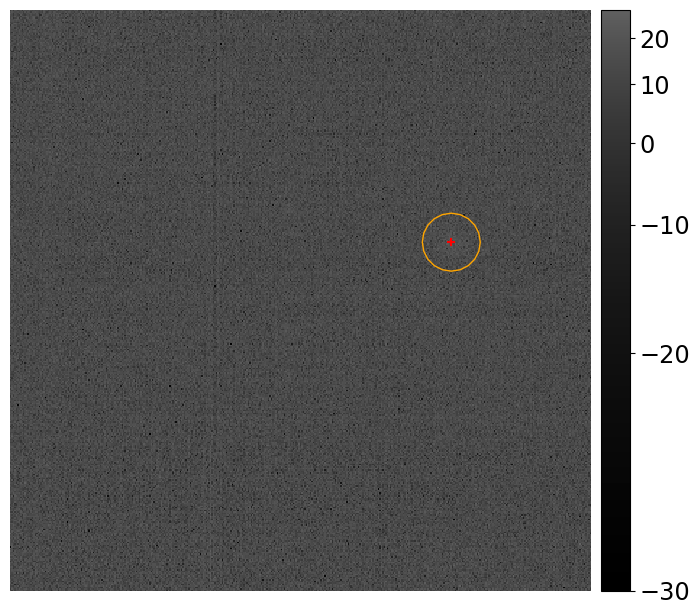

In [41]:
# Display the cutout and sources with afw display
image = cutout.image
plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('asinh', 'zscale')
afw_display.mtv(image)
plt.gca().axis('off')

# We use display buffering to avoid re-drawing the image
#  after each source is plotted
with afw_display.Buffering():
    for s in sources:
        afw_display.dot('+', s.getX(), s.getY(), ctype=afwDisplay.RED)
        afw_display.dot('o', s.getX(), s.getY(), size=20, ctype='orange')